# Analyzing Warframe's 2020 Usage Data

# What is Warframe?
Warframe is a multiplayer third-person shooter developed by Digital Extremes. Players play as a Tenno, an operator of the powerful Warframes, trying to keep the galaxy from falling into complete chaos. 

Digital Extremes is admirably public with their data, including a 2020 year-end divulgence of what players have been using in their missions. 

You can find their stats page [here](https://www.warframe.com/2020stats). You can also get the raw JSON file from [here.](https://n9e5v4d8.ssl.hwcdn.net/repos/WarframeUsageData2020.json)

While DE has already hosts some graphs to better display the data from this year, I'd like to take a deeper dive into some of it. For my purposes, I will be using only the PC playerbase's data.



In [57]:
import pandas as pd
from pandas.io.json import json_normalize
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"


In [58]:
df = pd.read_json('WarframeUsageData2020.json')
#Making it so the dataframe is only using the PC player data.
df = df['PC']
#Let's see what it looks like.
df

Melee        {'ACK & BRUNT': {'ALL': 0.0006748890661020001,...
Primary      {'ACCELTRA': {'ALL': 0.07952562439697501, '0':...
Secondary    {'ACRID': {'ALL': 0.0008164363367200001, '7': ...
Warframe     {'ASH': {'ALL': 0.001782014470978, '0': 0.0003...
Name: PC, dtype: object

# Analyzing the Popularity of Each Warframe

Right, so we have ourselves a list of all the Warframes currently in the game, plus the ratio of how long each Warframe is played across all Mastery Rankings - which shows how experienced each player is. 

You may have noticed that some Warframes show up twice on the list, once with just their name, and other times with "PRIME" appended to it. As part of their monetization model, Warframes are first released as their base version, and then a few years down the line the Prime model comes out, which features better stats and a fancy new look, though the gameplay remains the same. For our first bit of analysis, we'll be combining the base frame and (if it exists) the prime frame's playtime.

In [59]:
#So we're faced with a conundrum: We want to consolidate the stats from the PRIME frames into the base versions, 
#rather than keeping them seperate.

#We'll start by making a dictionary which will have the Warframe's name as the key and their ratio of playtime as the value.
#This can also be done with pandas df.filter() option, but I felt this was easier.
warframePlaytimeDict = {}

for warframeName in df['Warframe']:
    #Looking for any warframes with Prime in their name, so that we can add their playtime values to the 
    # base frame's playtime values.
    
    if 'PRIME' in warframeName:
        #We'll now use string slicing to remove the PRIME part. I.E. ASH PRIME becomes just ASH.
        nameWithoutPrime = warframeName[:-6]

        #Now we're going to search that name through our dictionary and see if it matches any existing entry.
        #The data is organized in such a way that the base frame's name comes first, then the PRIME version, 
        # allowing this to work.
        if nameWithoutPrime in warframePlaytimeDict.keys():
            #With this, we'll take the playtime value of the PRIME frame and add it to the base frame's. 
            warframePlaytimeDict[nameWithoutPrime] += df['Warframe'][warframeName]['ALL']

    else:
    #Assuming there's no PRIME in the name, then we can safely add it to our dictionary 
    # with its playtime value linked to it.
        warframePlaytimeDict[warframeName] = df['Warframe'][warframeName]['ALL']
        

Alright, so now we have a dictionary with the name of every Warframe and the percentage value of playtime each one got over 2020. We also have it so that if the frame has a Prime version, we combined the two playtime values into one. Now we can start graphing it.

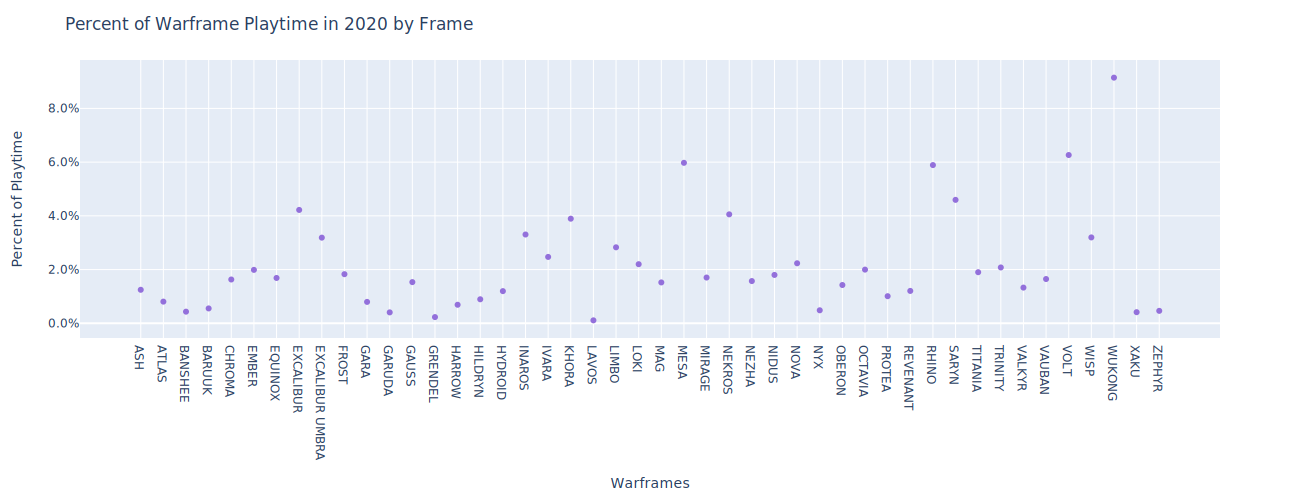

In [60]:

fig = px.scatter(x=warframePlaytimeDict.keys(), y=warframePlaytimeDict.values(),
    #Changing the labels/legend to be a bit more understandable.
    labels = {'x':'Warframe Name', 'y': 'Usage Percent'} 
    ).update_traces(marker=dict(color='MediumPurple'))
fig.update_layout(
    title = 'Percent of Warframe Playtime in 2020 by Frame',

    xaxis = dict(
        title = 'Warframes',
        #This will allow each frame's name to show up as a data tick.
        tickmode = 'linear',
        dtick = 1
    ),

    yaxis = dict(
        #This will show the y-axis values in percentage format, and clean up the point precision.
        tickformat= '0.1%',
        title = 'Percent of Playtime'
    )
)
#There's a lot of data points here, so we're going to widen the frame a bit.
fig.show(width = 1300, height =500)


# Analysis
According to the graph, the playtime for frames varies by quite a lot. Wukong, the melee-focused frame taking inspiration from *Journey to the West's* Sun Wukong is by far the most popular Warframe, across all Mastery Ratings. 
I would say this could be attributed to a few things:
<ul>
    <li>The parts required to craft the Wukong Warframe, in its base version or Prime version, are fairly easy to get. </li>
    <li>Wukong is an easy frame to pick up, with an emphasis on survivability, something which is attractive to new and experienced players alike. </li>
    <li>He does well in all types of content, unlike certain Warframes like Nidus which suffer from only being good on certain mission types, like Defense.</li>
</ul>

Conversely, the frame with the lowest playtime is Lavos. This should be taken with a grain of salt, however, because this data was collected over the course of 2020 and Lavos was only released on the 18th of December. Thus, we should look at another frame with low playtime, one that was not released during 2020. 

The next lowest playtime is Grendel who was released in 2019. I would say this can be attributed almost exclusively towards the difficulty of acquiring his crafting materials, which is a massive time-sink. Many players, including myself, put off acquiring him just because it was so much work. 

Two other Warframes, Nyx and Zephyr, also suffer from low playtime. Neither is particularly difficult to acquire. While Nyx has not received any significant changes, Zephyr just received a reworking of her kit. Time will tell whether that will salvage her playtime.




# Finding the Most Popular Weapons by Type
Warframe has three types of weapons. Primary weapons, secondary weapons, and melee weapons. Along with the aforementioned Warfames, the 2020 data also notes how much playtime each weapon had.
I will use pandas to find the three most popular weapons of each type and plot it. 

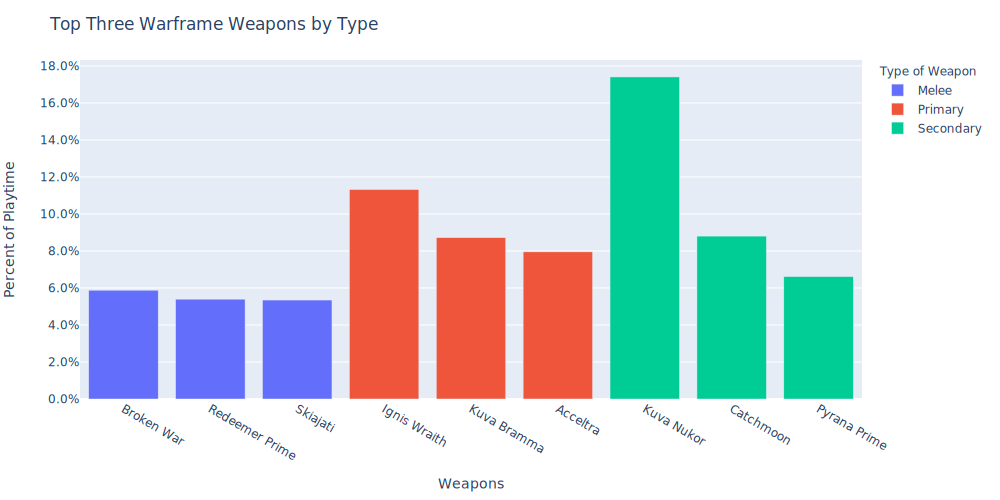

In [61]:
#We'll start by dropping the Warframes column as it's not in our scope for this part. This will leave the Primary, Secondary and Melee columns.
top3Subset = df.drop(['Warframe'])
#Next, we'll normalize the subset. The reason I'm doing this is to flatten it so that each column holds only a single value.
#This will make narrowing down our dataframe very easy.
top3Subset = pd.json_normalize(top3Subset)
#Once again, I'm going to gather data gathered across all mastery ratings. 
top3Subset = top3Subset.filter(like = '.ALL').transpose()
#So now we have a row for each weapon, with each column representing a weapon type. 
#We will now find the largest values for each column, thus finding the three most popular weapons of each type. 
weapons = []
for x in range (0, 3):
    #Iterating by column, and using dropna() to make it so we get only three rows per column/iteration.
    weapons.append(top3Subset.nlargest(3, [x]).dropna(axis=1).rename(
        #Next, we're going to rename the columns so they show what type of weapon they are.
        columns={0: "Melee", 1:'Primary', 2: 'Secondary'},
        #Finally, we'll use a lambda function to edit the weapon's name so that it no longer includes the ".ALL"
        #and we'll give it more appropriate capitalization.
        index =lambda x: x.replace('.ALL', '').title()
        ))

#Finally, combining the dataframes back into one.
weapons = pd.concat(weapons)

fig = px.bar(weapons, 
    #Once again, changing the labels/legend to be more understandable.
    labels = {'variable':'Type of Weapon', 'index': 'Weapon Name', 'value': 'Usage Percent'} 
    )

fig.update_layout(
    title = 'Top Three Warframe Weapons by Type',

    xaxis = dict(
        title = 'Weapons',
    ),

    yaxis = dict(
        tickformat= '0.1%',
        title = 'Percent of Playtime'
    ))
    
fig.show(width = 1000, height =500)


# Analysis by Type
## Melee
Melee weapons as a whole appear fairly diverse, with the top three weapons making up only 15% of the total playtime for that slot. Broken War, a straight sword, and Skiajati, a katana, are also some of the few weapons one receives from playing the story, so their high playtime is understandable. The gunblade Redeemer Prime is likely popular because of its incredible power and ease of crafting, being likely the easiest gunblade-class weapon to create. 
## Primary
For primary weapons, we see three weapons dominate 28% of the total playtime for that slot. The Ignis Wraith, a flamethrower, is a well-known favorite due to its easy crafting process, great power, and low Mastery Rating requirement. The Kuva Bramma is a more interesting case, particularly considering that it takes some work to obtain. It's very rare that a weapon is so powerful that it receives a direct nerf, but the Kuva Bramma managed to receive that dubious honor midway through 2020. Despite that, its total playtime remains very high. 
Lastly, there's the Acceletra, a micro-missile launcher. While the Acceletra is quite strong, its level of popularity was quite unexpected to me. The Acceletra may be popular to newer players for similar reasons to the Ignis Wraith: an easy crafting process and a low Mastery Rating requirement.
## Secondary
Lastly, for secondary weapons we see just three weapons taking up roughly a third of the total playtime for that slot, with the Kuva Nukor being by far the most popular weapon of 2020. The Kuva Nukor, a beam weapon which arcs to nearby targets, is well-known for being able to clear whole rooms. The Catchmoon modular part is in a sense multiple weapons, as this gun can actually be heavily customized. The Catchmoon is not the only weapon like this, but it was the only one popular enough to make it into this plot. Finally, there's the Pyrana Prime, a pistol-shotgun which was very easy to get in 2020, was easy to mod, and had fantastic damage output.

With over 110 weapons in the secondary slot alone, it is a little concerning that just three weapons take up such a large portion of the playtime. The Kuva Nukor could warrant a nerf, or some of the less popular guns could receive a buff to tighten the playtime figures. 

# What Are All the Experienced Players Using?
Now that we've found what's generally popular across all Mastery Ratings, it's time to see what the most experienced players are using. 
## Method
We'll be classifying experienced players as anyone Mastery Rating 25 or higher. According to Steam's global achievement stats, this encompasses about 5% of the playerbase that has beaten the tutorial. Just like in the previous graph, we'll be finding the top three pieces of equipment for each category, though this time we will also be looking for the three most popular Warframes. 
## How does one level up their Mastery Rating, anyways?
Mastery Rating experience points are gained by leveling up a piece of equipment to 30. What this means is that the higher Mastery Rating players have used more of the game's weaponry and Warframes, and have experienced more of what the game has to offer. It follows then that higher M.R. players are less constricted by limited resources and have greater choice in their loadouts.

In [62]:
#In this cell we'll be splitting and combining multiple times. 
#We'll begin by getting the columns that show the data for M.R. 25 and above players. 
masteryRatings = ['.25', '.26', '.27', '.28', '.29', '.30']
dataframesToCombine = []

#Normalizing it and setting the max_level to 1 makes every weapon have a column for each Mastery Rating's data.
highMRSubset = pd.json_normalize(df, max_level = 1)

for item in masteryRatings:
    # We'll then use filter to find the columns with the appropriate Mastery Rating.
    dataframesToCombine.append(highMRSubset.filter(like = item))

#Combining the seperate dataframes back together into one, this time with just the data for the Mastery Ratings that we want. 
combinedDF = pd.concat(dataframesToCombine, axis = 1)
combinedDF.index = ['Melee', 'Primary', 'Secondary', 'Warframe']
#Now, we're going to group each weapon and warframe's various M.R. values and average them out.
#Example: The data for Wukong Prime at M.R. 25 will be averaged with Wukong Prime at M.R. 26, M.R. 27, etc. 
#We'll then transpose it so the columns become rows, which makes it easier to read and enables us to use nlargest().  
grouped = combinedDF.groupby(lambda col: col[:-3], axis = 1).mean().transpose()
#Doing something similar to what we did to find the most popular weapons. Utilizing nlargest, splitting the dataframe up,
#then recombining it once we're done.
dataframesToCombine = []
for col in grouped.columns:
    dataframesToCombine.append(grouped.nlargest(3, col).dropna(axis=1).rename(index = lambda x: x.title()))
#Putting it all back together..    
finishedHighMRData = pd.concat(dataframesToCombine)



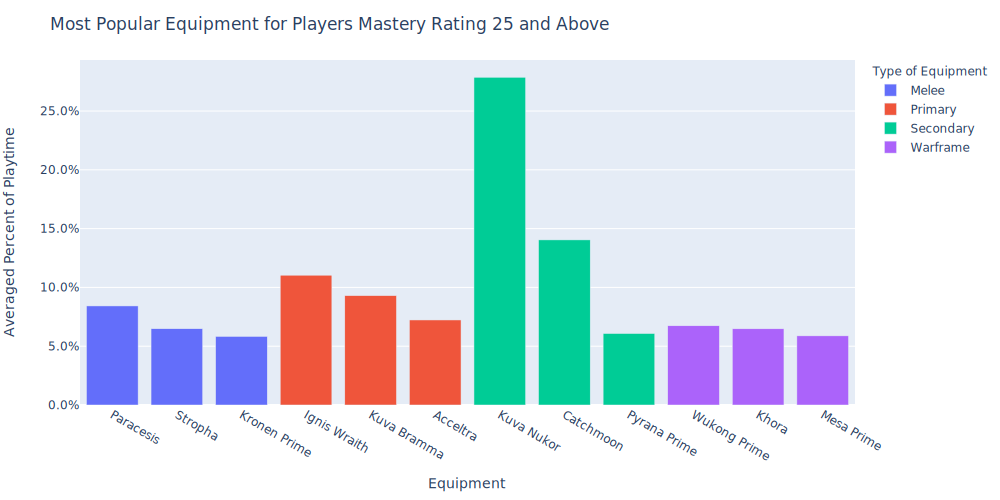

In [63]:
#Now to start graphing!
fig = px.bar(finishedHighMRData, 
    labels = {'variable':'Type of Equipment', 'index': 'Equipment Name', 'value': 'Usage Percent'}
    )
fig.update_layout(
    title = 'Most Popular Equipment for Players Mastery Rating 25 and Above',

    xaxis = dict(
        title = 'Equipment',
    ),

    yaxis = dict(
        tickformat= '0.1%',
        title = 'Averaged Percent of Playtime')
)

fig.show(width = 1000, height =500)


# Analysis by Type
## Melee
We find that high M.R. players have notably diffrent choices in melee weapons. Paracesis, a greatsword rewarded from a late-game story mission, is dominant. Paracesis holds some special traits that make it valuable for much of the content in the game, but the heavy time investment required to build it may have put off lower M.R. players. Stropha, a futuristic gunblade, is popular among high level players presumably for its incredible critical damage, and its effectiveness when pared with the Khora frame also seen on this plot. Lastly, the Kronen Prime tonfas are popular for their high damage output and unique moveset, but its crafting costs may have put less experienced players off. 
## Primary
Primary weapon usage is nearly the same as it is in the all Mastery Ratings graph. The Ignis Wraith, Kuva Bramma and Acceltra continue their reign.
## Secondary
Like with primary weapons, M.R. 25 and above players seem to use the same weaponry, but this time the Kuva Nukor's playtime values are even higher, accounting for over a quarter of all secondary weapon usage. The Catchmoon modular part also sees an appreciable bump of 5% more playtime compared to all Mastery Ratings. Lastly, the Pyrana Prime sees almost the exact same usage between the two datasets. 
## Warframes
While we see that Wukong is still the most popular frame, he does not have the same lead as before. The beastmaster Warframe Khora supercedes Volt as the second most popular choice while Mesa Prime retains her placement as the third most popular Warframe. Khora is well loved for her strong crowd-control abilities, while Mesa Prime is popular for her ability to clear whole rooms in seconds.  

# Final Thoughts
It is interesting that despite these players having considerably more choice in what they can use, their weaponry is largely the same as everyone else's. The playerbase in general seems to share similar sentiments of what is considered "good" and what isn't. Speaking anecdotally, the effectiveness of weaponry - and to a lesser extent, Warframes - varies <em>wildly</em>. Most of the weaponry I've used in Warframe simply isn't good enough to work in the content I want to do, so I don't think it's all that surprising that some weapons dominate the field. With that said, I think it's clear that some weapons are a little too dominant, such as the Kuva Nukor. Balance is tricky, but I do think some of the older weaponry could use some strong buffs to keep them at least partially relevant. 

I hope you enjoyed this dive into Warframe's data. It was certainly a fascinating dataset to explore, and I feel like I have a much better understanding of both pandas and Plotly. Lastly, I'd like to give a big thank you to Digital Extremes for publishing this data, and being so open with their development process in general. 